In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.\\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

.\data\factcheck.csv
.\data\liar.csv
.\data\md5sums.txt
.\data\politifact.csv


According to Jimmy Gomez,  **"When fake news is repeated, it becomes difficult for the public to discern what's real "**

Hence, in this notebook let's predict ✍ the fake news 📜 & keep on sharing the truth 🧾 to everyone across the universe👍

**IMPORTING LIBRARIES**

In [44]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
# printing the stopwords in English
print(stopwords.words('english'))
tqdm.pandas()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**PRE PROCESSING OF DATA**

In [47]:
news_data = pd.read_csv('./data/politifact.csv')
news_data.head()

,id,target,text,name,link,target_numeric
0,1,false,Does most of U.S. aid to foreign countries con...,Looking at “American aid to other countries … ...,https://www.politifact.com/factchecks/2023/nov...,0
1,2,true,"In a recent appearance in New Hampshire, Democ...",“We sell arms to 60% of the world's autocrats....,https://www.politifact.com/factchecks/2023/nov...,1
2,3,true,U.S. Sen. Ted Cruz wants people to know that T...,“We produce a lot more wind energy in Texas th...,https://www.politifact.com/factchecks/2023/nov...,1
3,4,false,An Instagram post attributes a dystopian state...,"Quotes House Speaker Mike Johnson as saying, “...",https://www.politifact.com/factchecks/2023/nov...,0
4,5,false,An Election Day glitch in eastern Pennsylvania...,"On Nov. 7, 2023, Pennsylvania voting machines ...",https://www.politifact.com/factchecks/2023/nov...,0


In [48]:
news_data.shape

(23640, 6)

In [49]:
# counting the number of missing values in the dataset
news_data.isnull().sum()

id                0
target            0
text              0
name              0
link              0
target_numeric    0
dtype: int64

In [50]:
# replacing the null values with empty string
news_data = news_data.fillna('')

In [51]:
# checking the number of missing values in the dataset
news_data.isnull().sum()

id                0
target            0
text              0
name              0
link              0
target_numeric    0
dtype: int64

In [52]:
# merging the author name and news title
news_data['content'] = news_data['name']+' '+news_data['text']

In [53]:
print(news_data['content'])

0        Looking at “American aid to other countries … ...
1        “We sell arms to 60% of the world's autocrats....
2        “We produce a lot more wind energy in Texas th...
3        Quotes House Speaker Mike Johnson as saying, “...
4        On Nov. 7, 2023, Pennsylvania voting machines ...
                               ...                        
23635    "New Mexico was 46th in teacher pay (when he w...
23636    "We now have the greatest income inequality si...
23637    "For every single scientist that tells you (gl...
23638    "Tommy Thompson is the father of welfare refor...
23639    "Tommy Thompson created the first school choic...
Name: content, Length: 23640, dtype: object


In [54]:
# separating the data & label

## Get the Independent Features
X = news_data.drop(columns='target_numeric', axis=1)
## Get the Dependent features
Y = news_data['target_numeric']

In [55]:
Y.value_counts()

target_numeric
1    13550
0    10090
Name: count, dtype: int64

In [56]:
X.shape

(23640, 6)

In [57]:
Y.shape

(23640,)

In [58]:
print(X)
print(Y)

          id       target                                               text  \
0          1        false  Does most of U.S. aid to foreign countries con...   
1          2         true  In a recent appearance in New Hampshire, Democ...   
2          3         true  U.S. Sen. Ted Cruz wants people to know that T...   
3          4        false  An Instagram post attributes a dystopian state...   
4          5        false  An Election Day glitch in eastern Pennsylvania...   
...      ...          ...                                                ...   
23635  23636  mostly-true  Richardson led a successful effort to raise te...   
23636  23637         true  Indeed, economists have found that the top tie...   
23637  23638        false  At a debate in South Carolina, Tancredo said h...   
23638  23639         true  While it is certainly risky to claim fatherhoo...   
23639  23640         true  The Milwaukee Parental Choice Program was esta...   

                                       

**STEMMING:**

* A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
* In simple words, Stemming is the process of reducing a word to its Root word.

* **EXAMPLES:** 

  1. actor, actress, acting --> act
  2. eating, eats, eaten --> eat

In [59]:
port_stem = PorterStemmer()

In [60]:
def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [61]:
news_data['content'] = news_data['content'].progress_apply(stemming)

100%|██████████| 23640/23640 [1:45:29<00:00,  3.73it/s]  


In [62]:
print(news_data['content'])

0        look american aid countri vast major militari ...
1        sell arm world autocrat world largest arm expo...
2        produc lot wind energi texa california u sen t...
3        quot hous speaker mike johnson say everi woman...
4        nov pennsylvania vote machin flip vote evid el...
                               ...                        
23635    new mexico th teacher pay elect th richardson ...
23636    greatest incom inequ sinc great depress inde e...
23637    everi singl scientist tell global warm happen ...
23638    tommi thompson father welfar reform creat grou...
23639    tommi thompson creat first school choic progra...
Name: content, Length: 23640, dtype: object


In [63]:
#separating the data and label
X = news_data['content'].values
Y = news_data['target_numeric'].values

In [64]:
print(X)

['look american aid countri vast major militari aid u aid foreign countri consist militari assist democrat presidenti candid mariann williamson said nov town hall store manchest new hampshir look american aid last decad mean american aid countri williamson said remark captur politifact partner wmur tv new hampshir vast major militari aid sell arm world autocrat world largest arm export realiti offici feder data show u militari aid account minor overal u foreign aid check portion arm export separ'
 'sell arm world autocrat world largest arm export recent appear new hampshir democrat presidenti candid mariann williamson said u world biggest arm export sell wide autocrat countri look american aid last decad mean american aid countri williamson said nov event store manchest new hampshir vast major militari aid sell arm world autocrat world largest arm export comment captur politifact partner wmur tv new hampshir correct u world largest arm export u sell heavili autocrat govern check statem

In [65]:
print(Y)

[0 1 1 ... 0 1 1]


In [66]:
Y.shape

(23640,)

**TF-IDF stands for “Term Frequency – Inverse Document Frequency ”**

* TF-IDF is a numerical statistic which measures the importance of the word in a document.

* Term Frequency : Number of time a word appears in a text document.
* Inverse Document Frequency : Measure the word is a rare word or common word in a document.

In [67]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [68]:
print(X)

  (0, 45849)	0.12151202780980921
  (0, 45694)	0.15196302688736596
  (0, 45466)	0.26045426561165963
  (0, 43901)	0.18815764812575825
  (0, 42542)	0.06830338585444777
  (0, 41861)	0.08270280454653609
  (0, 39487)	0.09171876767928862
  (0, 37546)	0.03834398129556141
  (0, 36992)	0.07169029245374932
  (0, 36895)	0.08335910983484562
  (0, 35835)	0.047500886325641256
  (0, 34348)	0.07590420607948974
  (0, 33775)	0.08496847549162335
  (0, 32391)	0.05421641704669776
  (0, 32035)	0.07844382646495275
  (0, 31841)	0.046732501726201976
  (0, 30506)	0.09204396733530455
  (0, 29893)	0.07057296883438956
  (0, 29209)	0.052046857480921645
  (0, 28784)	0.06655987444080329
  (0, 28067)	0.0756415798899204
  (0, 26436)	0.07519547766474838
  (0, 26306)	0.2903564275933209
  (0, 25629)	0.05189037248509827
  (0, 24936)	0.15949517215085784
  :	:
  (23639, 25223)	0.07261817203427252
  (23639, 24590)	0.04148095064455053
  (23639, 24098)	0.07139944218554042
  (23639, 23765)	0.0643992568839962
  (23639, 23222)	0.05

**SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:**

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

**LOGESTIC REGRESSION:**

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [70]:
model = LogisticRegression()

In [71]:
model.fit(X_train, Y_train)

LogisticRegression()

In [72]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [73]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.8280985617597293


In [74]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [75]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7785532994923858


**CONFUSION MATRIX:**

* The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label. 



In [76]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


        

    
    

In [77]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**CLASSIFICATION MODEL : MULTINOMIAL NAIVE BAYES**

* Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP)

* Multinomial Naïve Bayes uses term frequency i.e. the number of times a given term appears in a document. Term frequency is often normalized by dividing the raw term frequency by the document length


In [78]:
#let's implement the model : Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.761
Confusion matrix, without normalization


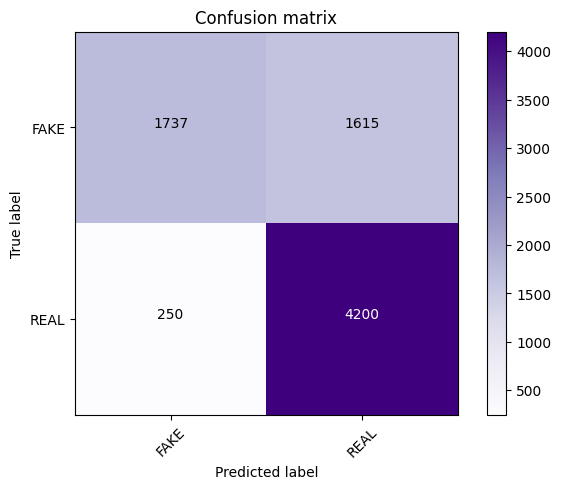

In [79]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X1_train, Y1_train)
prediction1 = classifier.predict(X1_test)
score = metrics.accuracy_score(Y1_test, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(Y1_test, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])

**CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER**

* Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

In [80]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y, test_size=0.33, random_state=42)

C:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy:   0.709
Confusion matrix, without normalization


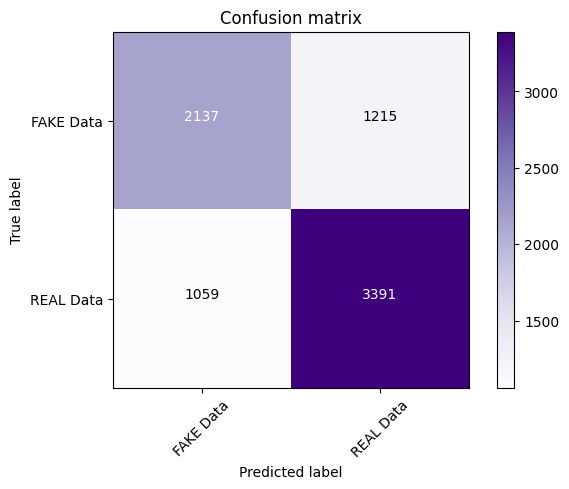

In [81]:
#lets implemet the algorithm : Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

linear_clf.fit(X2_train, Y2_train)
prediction2 = linear_clf.predict(X2_test)
score = metrics.accuracy_score(Y2_test, prediction2)
print("accuracy:   %0.3f" % score)
cm2 = metrics.confusion_matrix(Y2_test, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**BUILDING A PREDICTIVE SYSTEM:**

Building a predictive system inorder to find that the inital word in the dataset is real or fake using LogisticRegression model: 

In [82]:
X_new = X_test[0]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [83]:
print(Y_test[0])

1


Building a predictive system inorder to find that the inital word in the dataset is real or fake using Multinomial Naive Bayes model: 

In [84]:
X1_new = X1_test[0]

prediction = model.predict(X1_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [85]:
print(Y1_test[0])

0


Building a predictive system inorder to find that the inital word in the dataset is real or fake using Passive Aggressive Classifier: 

In [86]:
X2_new = X2_test[0]

prediction = model.predict(X2_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [87]:
print(Y2_test[0])

0


**CLASSIFICATION REPORT:**

* A Classification report is used to measure the quality of predictions from a classification algorithm.

* It is used to show the precision, recall, F1 Score, and support of your trained classification model.

Classification report for logistic regression model:

In [88]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2018
           1       0.76      0.89      0.82      2710

    accuracy                           0.78      4728
   macro avg       0.79      0.76      0.76      4728
weighted avg       0.78      0.78      0.77      4728


In [89]:
from sklearn.metrics import classification_report
print(classification_report(Y1_test,prediction1))

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      3352
           1       0.72      0.94      0.82      4450

    accuracy                           0.76      7802
   macro avg       0.80      0.73      0.73      7802
weighted avg       0.79      0.76      0.75      7802


In [90]:
from sklearn.metrics import classification_report
print(classification_report(Y2_test,prediction2))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65      3352
           1       0.74      0.76      0.75      4450

    accuracy                           0.71      7802
   macro avg       0.70      0.70      0.70      7802
weighted avg       0.71      0.71      0.71      7802


**MODEL COMPARISON**

Hence, in this dataset we can observe that

* Logistic Regression : Accuracy is 0.98

* Multinomial Naive Bayes : Accuracy is 0.95

* Passive Aggressive Classifier : Accuracy is 0.99

In [91]:
print("Successfully we have predicted the fake news using logistic regression, Multinomial Naive Bayes & Passive Aggressive Classifier ")

Successfully we have predicted the fake news using logistic regression, Multinomial Naive Bayes & Passive Aggressive Classifier 


According to Dr.Karishma Ahuja, "**Speak your truth, Speaking your truth is an act of loving & respecting yourself**"

**Hence let's speak truth & every glittering ounce of it will be cherished,  hoarded, worshipped & fondled like a priceless diamond !!**